# RidgeRegression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### The Model

In [190]:
def ridge_regression(X, y, max_iter=10000, learning_rate=0.01, tolerance=0.1, max_grad=1e6, lambda_regul=0.0,
                              learning_rate_decay=True):
    '''Runs Gradient Descent on the data.
    Returns Parameters learned by the model and costs, scores and gradient magnitudes lists 
    computed so far during training respectively in order.
    '''
    
    m = X.shape[0]                                      # Training Examples
    n = X.shape[1]                                      # No. of features
    X = np.hstack((np.ones((m,1)), X))                  # Adding a column of ones for 0th feature i.e. Intercept
    w = np.zeros((n+1, n))#random.randn(n+1, 1) * np.sqrt(2.0 / n)      # Random (He) initialization of weights
    costs = []
    scores = []
    gradient_magnitudes = []
    
    for t in range(max_iter):
        
        y_cap = np.matmul(X, w)
        error = y - y_cap
        dw = -2 * np.matmul(X.T, error)
        dw = np.clip(dw, -max_grad, max_grad)           # Avoiding Vanishing/Exploding Gradients
        w = w * (1 - 2 * learning_rate * lambda_regul) # Weights Penalization except intercept
        w -= learning_rate * dw
        
        cost = np.matmul(error.T, error)
        score = 1 - (cost / ((y - y.mean()) ** 2).sum()) # coefficient R^2
        costs.append(cost.flatten()[0])
        scores.append(score.flatten()[0])
        
        gradient_magnitude = np.linalg.norm(dw)
        gradient_magnitudes.append(gradient_magnitude)
        if gradient_magnitude < tolerance:
            break
            
        if learning_rate_decay and (t+1) % 100 == 0:
            learning_rate = learning_rate / np.sqrt(t)    # Learning rate decay over every 100th iteration
        
    return w, costs, scores, gradient_magnitudes

def score(X, y, w):
    '''Returns the coefficient R^2 score of the model
    '''
    if X.shape[1] < w.shape[0]:
        X = np.hstack((np.ones((X.shape[0],1)), X))
    y_cap = np.matmul(X, w)
    error = y - y_cap
    cost = np.matmul(error.T, error)
    score = 1 - (cost / ((y - y.mean()) ** 2).sum())
    
    return score.flatten()[0]

def predict(X, w):
    
    if X.shape[1] < w.shape[0]:
        X = np.hstack((np.ones((X.shape[0],1)), X))
    
    return np.matmul(X, w)

def generate_polynomial_features(x, degree=2):
    X = np.empty((x.shape[0], degree), dtype=x.dtype)
    
    for i in range(degree):
        X[:,i] = x[:,0] ** (i+1)
    
    return X
    

### Linear Data with noise and outliers

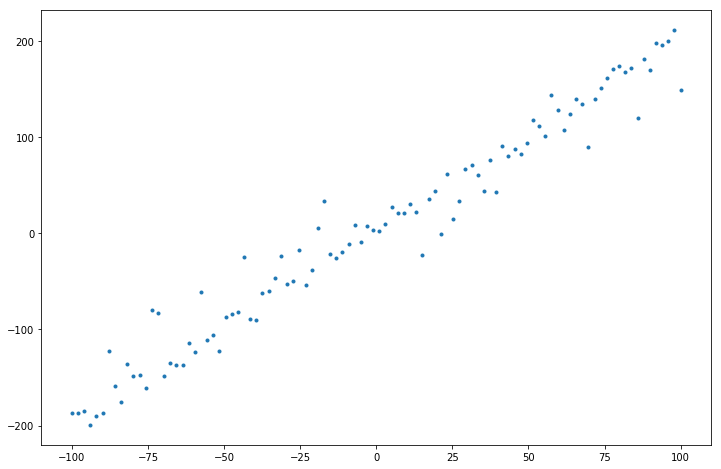

In [64]:
x = np.linspace(-100,100,100).reshape((-1,1))
y =  2 * x + 5
y = y + np.random.randn(x.shape[0],1) * 10                  # Adding noise to data
outlier_indices = np.random.randint(0, 50, 10)
y[outlier_indices] = y[outlier_indices] + 50               # Adding outliers
outlier_indices = np.random.randint(50, 100, 10)
y[outlier_indices] = y[outlier_indices] - 50               # Adding outliers
plt.figure(figsize=(12,8))
plt.plot(x[:,0], y, '.')

### Generating Polynomial Features

In [65]:
X = generate_polynomial_features(x, degree=3)
X.shape

(100, 3)

### Fitting non-regularized model on Polynomial Features

0.920049501372424

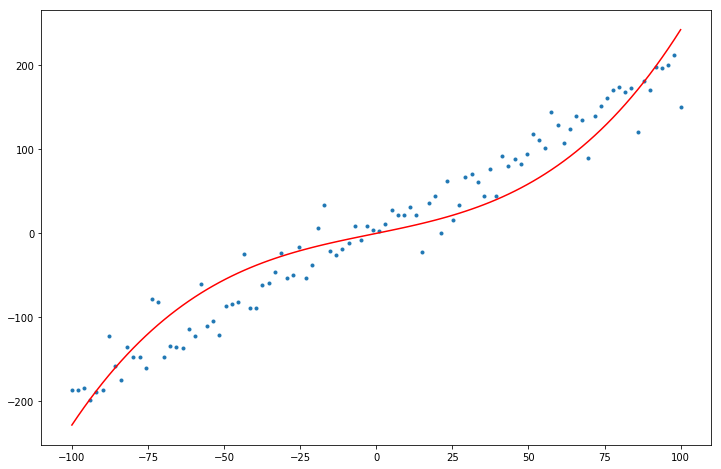

In [104]:
w, costs, _, _ = ridge_regression(X, y, max_grad=100, tolerance=200)
plt.figure(figsize=(12,8))
plt.plot(X[:,0], y, '.' , X[:,0], predict(X,w), 'r')
score(X,y,w)

We can clearly see the effects of outliers. The model is inclined towards the outliers.

### Fitting a regularized model on Polynomial Features

0.9592320386733447

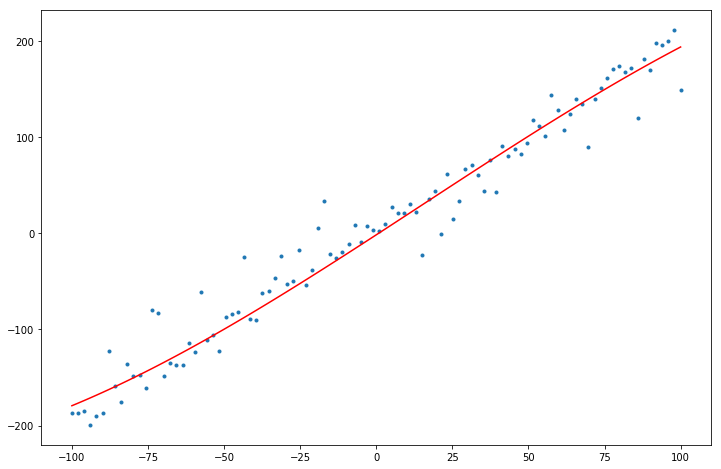

In [110]:
w, costs, _, _ = ridge_regression(X, y, max_grad=100, lambda_regul=0.1)
plt.figure(figsize=(12,8))
plt.plot(X[:,0], y, '.' , X[:,0], predict(X,w), 'r')
score(X,y,w)

The regularized model is more smoothly fitting the general trend of the data.

### How to choose lambda_regul?

#### k-fold cross validation

In [402]:
def k_fold_cross_validation(X, y, lambda_regul_list, k=10):
    
    m = X.shape[0]                            # No. of examples
    n = X.shape[1]                            # No. of features
    
    train_scores = []
    validation_scores = []
    
    for lambda_regul in lambda_regul_list:
        
        train_score = 0
        validation_score = 0
        
        for i in range(k):
            
            start = (m * i) // k
            end = (m * (i + 1)) // k-1
            
            X_valid = X[start:end+1, :]
            y_valid = y[start:end+1, :]
            
            X_train = np.append(X[:start, :], X[end+1:, :], axis=0)
            y_train = np.append(y[:start, :], y[end+1:, :], axis=0)
            
            w, _, _, _ = ridge_regression(X_train, y_train, max_grad=100, lambda_regul=lambda_regul)
            
            train_score += score(X_train, y_train, w)
            validation_score += score(X_valid, y_valid, w)
            
        train_score /= k
        train_scores.append(train_score)
        validation_score /= k
        validation_scores.append(validation_score)
    
    return train_scores, validation_scores        

#### Data

In [403]:
df = pd.read_csv('data/LinearRegression_kc_house_data.csv')[['sqft_living', 'price']].dropna().sort_values(
    ['sqft_living', 'price'])
df.head()

,sqft_living,price
19452,290.0,142000
15381,370.0,276000
860,380.0,245000
18379,384.0,265000
4868,390.0,228000


#### 8 degree polynomial features

In [404]:
x = np.array(df['sqft_living']).reshape(-1,1)
y = np.array(df['price']).reshape(-1,1)
X = generate_polynomial_features(x, degree=8)
X.shape, y.shape

((21605, 8), (21605, 1))

#### Train Test Split and normalization

In [405]:
means = np.mean(X, axis=0)
stds = np.std(X, axis=0)
X = (X - means) / stds

train_size = int(0.8*X.shape[0])
random_indices = np.random.permutation(X.shape[0])
X_train = X[random_indices[:train_size], :]
X_test = X[random_indices[train_size:], :]
y_train = y[random_indices[:train_size], :]
y_test = y[random_indices[train_size:], :]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17284, 8) (4321, 8) (17284, 1) (4321, 1)


#### Running k-fold cross validation for different values of lambda_regul

In [422]:
lambda_regul_list = np.logspace(-5, 2, num=10)
train_scores, validation_scores = k_fold_cross_validation(X_train, y_train, lambda_regul_list)

#### Training model for the best value of lambda_regul determined by the k-fold cross validation

In [430]:
w, _, _, _ = ridge_regression(X_train, y_train, max_grad=1e7, lambda_regul=lambda_regul_list[np.argmax(validation_scores)])

0.5428979581877116

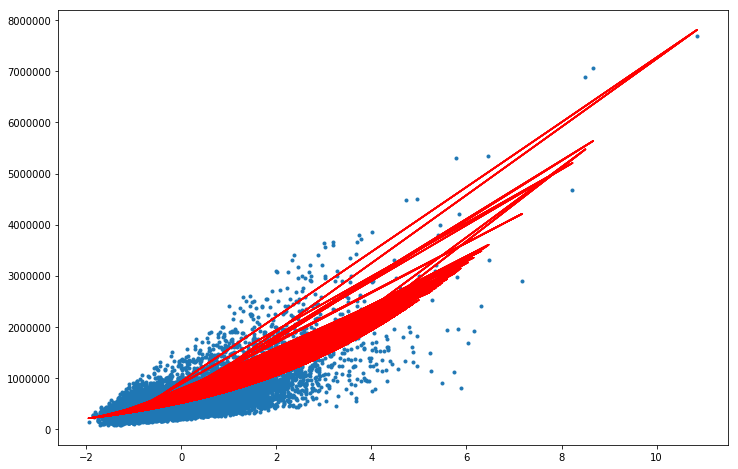

In [442]:
plt.figure(figsize=(12,8))
plt.plot(X_train[:, 0], y_train[:, 0], '.', X_train[:, 0], predict(X_train, w), 'r')
score(X_train, y_train, w)

We can see that instead of having a simple linear relationship or a complex polynomial relationship, our model is somewhere between these two.

0.47791255289666545

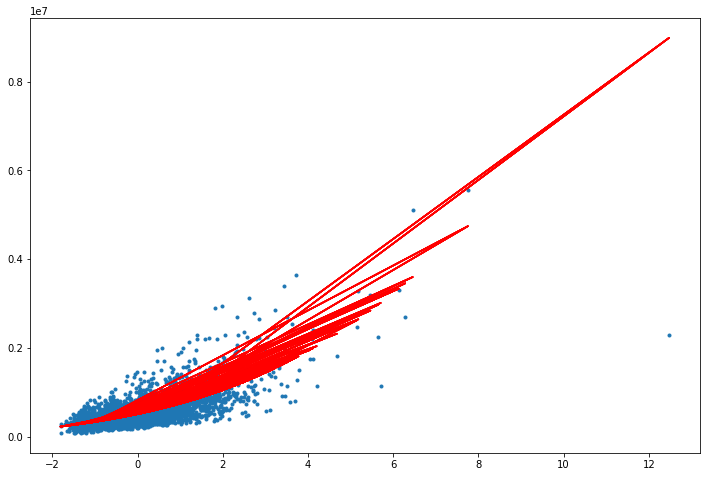

In [443]:
plt.figure(figsize=(12,8))
plt.plot(X_test[:, 0], y_test[:, 0], '.', X_test[:, 0], predict(X_test, w), 'r')
score(X_test, y_test, w)

Our model is also doing good on test data.